In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(20987, 28)
(20987, 3)


In [6]:
X_motion_CoM_continuous[0]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00, -4.96986205e-03,
       -4.08022931e-03, -1.09604628e-03,  1.22067254e-03, -7.11765578e-04,
       -6.25571855e-03,  2.29490617e-01,  1.71660343e-01, -4.07593556e-01,
        2.33458057e-01, -1.69934576e-01, -4.07590576e-01, -2.44067879e-01,
        1.71401114e-01, -4.07586282e-01, -2.47972604e-01, -1.69831881e-01,
       -4.07582734e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [7]:
Y_motion_CoM_continuous[0]

array([ 8.73479464e-03, -5.64902313e-03,  2.51590148e-05])

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(10339, 28)
(10339, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :]

array([0.10000000149, 0.0, 0.0, -0.000890185791332, -0.00484342625699,
       -0.0016179894701, -0.00407560999425, -0.00107515501585,
       -0.00510968513852, 0.23051781299999163, 0.1655742714433,
       -0.40774758989619997, 0.2341179489999945, -0.1641604241797,
       -0.4077428318662, -0.2458713250000102, 0.1643310085713,
       -0.4077813050943, -0.24857248099999651, -0.1633396735827,
       -0.40777665639239996, False, True, True, False, 0.10000000149, 0.0,
       0.0], dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.008710594356770684, -0.005823853354034292,
       0.00010580817889640592], dtype=object)

### Linear Regression

In [13]:
# Input
"""
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
#               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))
"""

# Input
X = np.hstack((X_motion_CoM_FR_RL[:, -3:], # Current motion command
               np.array([X_motion_CoM_FR_RL[:, 9]]).T,
               np.array([X_motion_CoM_FR_RL[:, 12]]).T,
               np.array([X_motion_CoM_FR_RL[:, 15]]).T,
               np.array([X_motion_CoM_FR_RL[:, 18]]).T))
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.969905661851494
RMSE:  0.007271649650893406
The lowest error is:  2.3292049183137875e-06
The highest error is:  0.07557961172649871
The avg. error is:  0.0039119241793212816


In [13]:
model_fr_com_x.coef_

array([[ 1.48641050e-02,  1.07239764e-02,  1.40597484e-04,
         1.20672771e-01, -3.23863334e-02, -1.57938089e-05,
         9.72984145e-02, -3.49357179e-02,  1.38407569e-01,
        -5.54173144e-02,  1.46893567e-01, -7.03063941e-02,
         6.74325930e-02, -3.87290870e-02]])

In [14]:
model_fr_com_x.intercept_

array([-0.0041092])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[0.00629774]]


Text(0, 0.5, 'Predictions')

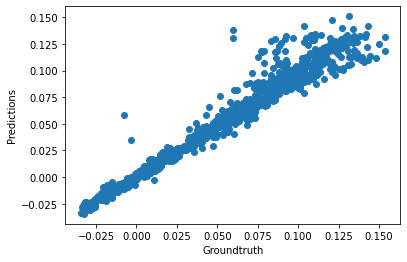

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fr_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
#               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9605322383669894
RMSE:  0.00806225720484086
The lowest error is:  6.739116017052266e-08
The highest error is:  0.08934763586883154
The avg. error is:  0.0039986319030863434


In [21]:
model_fr_com_y.coef_

array([[ 1.68883095e-02,  1.63399567e-02,  3.46143540e-05,
        -2.81771090e-02,  1.50141917e-01,  2.87168983e-04,
         2.17650440e-02,  4.78527106e-02,  8.21699342e-02,
         1.83301631e-01,  9.41406640e-02,  1.62310957e-01,
         2.71870847e-04,  3.38683919e-02]])

In [22]:
model_fr_com_y.intercept_

array([-0.00285801])

Text(0, 0.5, 'Predictions')

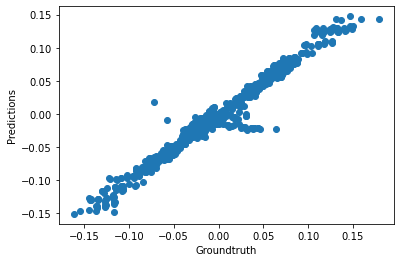

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fr_com_y

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")

## Predict CoM -> Yaw

In [27]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # Current motion command
#               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9808452376824365
RMSE:  0.004677509842849872
The lowest error is:  1.483580897166238e-07
The highest error is:  0.12937774660931206
The avg. error is:  0.001880648323090371


In [28]:
model_fl_com_theta.coef_

array([[-0.00680172,  0.00295698,  0.10619207,  0.00227804, -0.00216108,
         0.02926511,  0.01948711, -0.02309218,  0.04157076, -0.02121429,
         0.01611205, -0.03096961,  0.01646793,  0.00401436]])

In [29]:
model_fl_com_theta.intercept_

array([0.00014209])

Text(0, 0.5, 'Predictions')

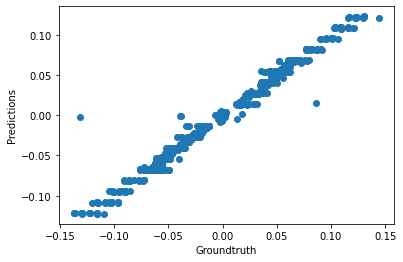

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")